In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

# project-specific custom functions
## export the path to custom modules
sys.path.append("../functions")
## import functions
from data_loading import load_data, get_label_name_from_filename

RSEED = 42
sns.set_theme(style="white", palette=None)

2024-05-23 22:43:07.312420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 22:43:08.848002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dir_data_base__relative = "../data/dataset_split_categories/"  # the relative directory path to all data files
dir_data_train = dir_data_base__relative+"train"
dir_data_val = dir_data_base__relative+"validation"
dir_data_test = dir_data_base__relative+"test"

In [3]:
IMG_SIZE_height, IMG_SIZE_width = 224, 224
BATCH_SIZE = 32

def get_dataset(data_dir, shuffle_flag):
    return tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(IMG_SIZE_height, IMG_SIZE_width),
    batch_size=BATCH_SIZE,
    shuffle=shuffle_flag,
    seed=RSEED,
    pad_to_aspect_ratio=True
)

dataset_train = get_dataset(data_dir=dir_data_train, shuffle_flag=True)
dataset_validation = get_dataset(data_dir=dir_data_val, shuffle_flag=False)
dataset_test = get_dataset(data_dir=dir_data_test, shuffle_flag=False)

Found 12955 files belonging to 8 classes.


2024-05-23 22:43:12.882126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 22:43:13.095614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 22:43:13.095706: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 22:43:13.097917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 22:43:13.098003: I external/local_xla/xla/stream_executor

Found 1647 files belonging to 8 classes.
Found 1886 files belonging to 8 classes.


In [4]:
y_true_train = []
for _, lbl in dataset_train:
    y_true_train.extend(lbl.numpy())
y_true_train = np.array(y_true_train)

class_sums = y_true_train.sum(axis=0)
total_sum = y_true_train.sum(axis=(0, 1))
inv_class_ratios = 1 / (class_sums / total_sum)
inv_class_ratios = inv_class_ratios / np.sum(inv_class_ratios)

class_weight_dict = {k:v for (k,v) in zip(range(8), inv_class_ratios)}

2024-05-23 22:43:20.416931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
prebuilt_model = tf.keras.applications.ConvNeXtXLarge(include_top=False, pooling="max")
prebuilt_model.trainable = False

data_aug_layer = tf.keras.Sequential()
data_aug_layer.add(tf.keras.layers.RandomRotation(factor=0.1))
data_aug_layer.add(tf.keras.layers.RandomFlip(mode="horizontal"))
data_aug_layer.add(tf.keras.layers.RandomContrast(factor=0.4))
data_aug_layer.add(tf.keras.layers.RandomBrightness (factor=0.3))

model = tf.keras.Sequential()

model.add(data_aug_layer)
model.add(prebuilt_model)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, name="Dense1", kernel_initializer="he_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(0.2, name="Dropout1"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, name="Dense2", kernel_initializer="he_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(0.2, name="Dropout2"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, name="Dense3", kernel_initializer="he_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(0.2, name="Dropout3"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, name="Dense4", kernel_initializer="he_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(0.2, name="Dropout4"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(8, name="Final_output", activation="softmax"))

In [6]:
'''
for batch, labels in dataset_train:
    x = batch
    y = labels
    break

img = batch[7]
img = img[tf.newaxis, ...]
img_list = [img]
for _ in range(5+1):
    img_list.append(data_aug_layer(img))

label_list = ["original photo"] + 5*["modified photo"]
#
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, im, lab in zip(axes.flatten(), img_list, label_list):
    ax.imshow(im[0]/255.0)
    ax.set_axis_off()
    ax.set_title(lab)
'''

'\nfor batch, labels in dataset_train:\n    x = batch\n    y = labels\n    break\n\nimg = batch[7]\nimg = img[tf.newaxis, ...]\nimg_list = [img]\nfor _ in range(5+1):\n    img_list.append(data_aug_layer(img))\n\nlabel_list = ["original photo"] + 5*["modified photo"]\n#\nfig, axes = plt.subplots(2, 3, figsize=(15, 10))\nfor ax, im, lab in zip(axes.flatten(), img_list, label_list):\n    ax.imshow(im[0]/255.0)\n    ax.set_axis_off()\n    ax.set_title(lab)\n'

In [7]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [8]:
checkpoint_path = "../models/snapshots/cp_{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

n_batches = len(dataset_train)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=3*n_batches,
                                                 verbose=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=10,
                                               verbose=1,
                                               start_from_epoch=10,
                                               restore_best_weights=True)

In [9]:
history = model.fit(
    dataset_train,
    validation_data=dataset_validation,
    verbose=1,
    callbacks=[cp_callback, es_callback],
    epochs=30)

Epoch 1/30


2024-05-23 22:43:53.950335: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716497034.856076    1733 service.cc:145] XLA service 0x7f37406d2d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716497034.856143    1733 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
I0000 00:00:1716497035.773856    1733 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


405/405 ━━━━━━━━━━━━━━━━━━━━ 1742s 4s/step - accuracy: 0.3342 - loss: 1.9523 - val_accuracy: 0.5756 - val_loss: 1.1348
Epoch 2/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 1695s 4s/step - accuracy: 0.5407 - loss: 1.2348 - val_accuracy: 0.5489 - val_loss: 1.1954
Epoch 3/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.5988 - loss: 1.0953
Epoch 3: saving model to ../models/snapshots/cp_0003.weights.h5
405/405 ━━━━━━━━━━━━━━━━━━━━ 1699s 4s/step - accuracy: 0.5988 - loss: 1.0952 - val_accuracy: 0.5228 - val_loss: 1.2524
Epoch 4/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 1694s 4s/step - accuracy: 0.6195 - loss: 1.0293 - val_accuracy: 0.5234 - val_loss: 1.2679
Epoch 5/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 1692s 4s/step - accuracy: 0.6445 - loss: 0.9757 - val_accuracy: 0.5513 - val_loss: 1.1877
Epoch 6/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.6554 - loss: 0.9452
Epoch 6: saving model to ../models/snapshots/cp_0006.weights.h5
405/405 ━━━━━━━━━━━━━━━━━━━━ 1695s 4s/step - accuracy: 0.6554 - loss: 0.94

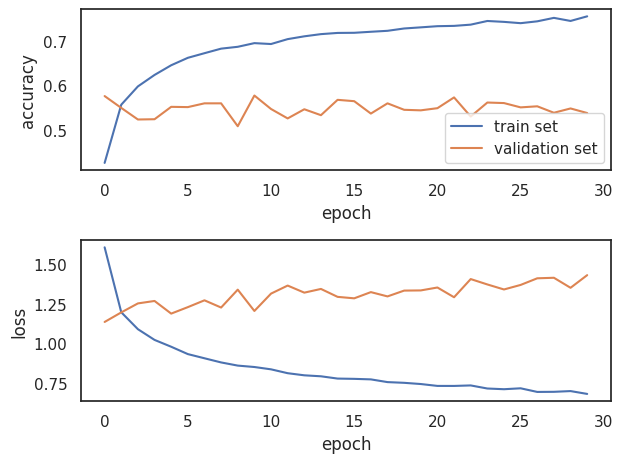

In [10]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['accuracy'],label='train set')
ax[0].plot(history.history['val_accuracy'],label='validation set')
ax[0].set(xlabel='epoch',
          ylabel='accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'],label='train')
ax[1].plot(history.history['val_loss'],label='val')
ax[1].set(xlabel='epoch',
          ylabel='loss')
# ax[1].legend()
fig.tight_layout()

In [11]:
y_pred_test = model.predict(dataset_test)
max_indices = np.argmax(y_pred_test, axis=1)
y_pred_test_ohe = np.zeros_like(y_pred_test)
y_pred_test_ohe[np.arange(y_pred_test.shape[0]), max_indices] = 1.0

59/59 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step


In [12]:
y_true_test = []
for _, lbl in dataset_test:
    y_true_test.extend(lbl.numpy())
y_true_test = np.array(y_true_test)
print(y_true_test.shape)

(1886, 8)


2024-05-24 13:28:14.549664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'antelope_duiker'),
  Text(1, 0, 'bird'),
  Text(2, 0, 'blank'),
  Text(3, 0, 'civet_genet'),
  Text(4, 0, 'hog'),
  Text(5, 0, 'leopard'),
  Text(6, 0, 'monkey_prosimian'),
  Text(7, 0, 'rodent')])

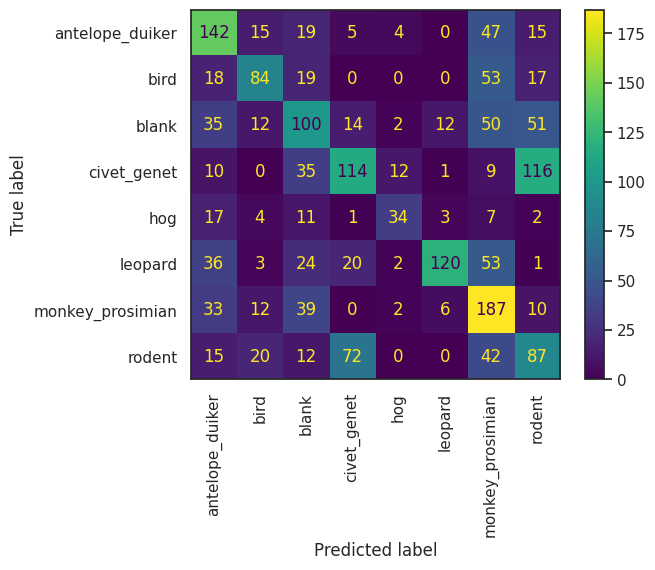

In [13]:
cm = confusion_matrix(np.argmax(y_true_test, axis=1), np.argmax(y_pred_test_ohe, axis=1))

ConfusionMatrixDisplay.from_predictions(np.argmax(y_true_test, axis=1), np.argmax(y_pred_test_ohe, axis=1), display_labels=dataset_test.class_names)
plt.xticks(rotation=90)

In [14]:
model.evaluate(dataset_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step - accuracy: 0.4830 - loss: 1.2940


[1.5056155920028687, 0.46023330092430115]

In [15]:
model.save("../models/ConvNeXtXLarge_v2.keras")

In [16]:
dataset_test.class_names

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']